In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms, datasets


In [3]:
import time
import os
import copy

plt.ion()

In [13]:
data_transforms = {
    'train': transforms.Compose([
            transforms.RandomResizedCrop(1000),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])      
}

In [10]:
dataDir = 'block'
imageDatasets = {
    x: datasets.ImageFolder(os.path.join(dataDir, x), data_transforms[x]) for x in ['train', 'val']
}

dataLoader = {
    x: torch.utils.data.DataLoader(imageDatasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']
}

datasetSizes = {
    x: len(imageDatasets[x]) for x in ['train', 'val']
}

classNames = imageDatasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [14]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

    plt.pause(0.001)

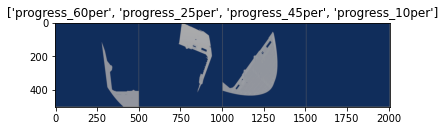

In [15]:
inputs, classes = next(iter(dataLoader['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[classNames[x] for x in classes])